In [1]:
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py
from scipy.ndimage import gaussian_filter
import matplotlib.image as mpimg

# Functions to read the data

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

# Loading the Data

In [3]:
fns_1 = ["H-H1_LOSC_4_V2-1126259446-32.hdf5", 
        "L-L1_LOSC_4_V2-1126259446-32.hdf5", 
        "GW150914_4_template.hdf5"]

fns_2 = ["H-H1_LOSC_4_V2-1128678884-32.hdf5", 
        "L-L1_LOSC_4_V2-1128678884-32.hdf5", 
        "LVT151012_4_template.hdf5"]

fns_3 = ["H-H1_LOSC_4_V2-1135136334-32.hdf5", 
        "L-L1_LOSC_4_V2-1135136334-32.hdf5", 
        "GW151226_4_template.hdf5"]

fns_4 = ["H-H1_LOSC_4_V1-1167559920-32.hdf5", 
        "L-L1_LOSC_4_V1-1167559920-32.hdf5",
        "GW170104_4_template.hdf5"]

In [4]:
# _h = hanford, _l = livingston
strain_h = np.zeros((131072, 4))
strain_l = np.zeros((131072, 4))
template_h = np.zeros((131072, 4))
template_l = np.zeros((131072, 4))

strain_h_1, dt_h_1, utc_h_1 = read_file(fns_1[0])
strain_l_1, dt_l_1, utc_l_1 = read_file(fns_1[1])
template_h_1, template_l_1 = read_template(fns_1[2])
strain_h[:, 0] = strain_h_1
strain_l[:, 0] = strain_l_1
template_h[:, 0] = template_h_1
template_l[:, 0] = template_l_1

strain_h_2, dt_h_2, utc_h_2 = read_file(fns_2[0])
strain_l_2, dt_l_2, utc_l_2 = read_file(fns_2[1])
template_h_2, template_l_2 = read_template(fns_2[2])
strain_h[:, 1] = strain_h_2
strain_l[:, 1] = strain_l_2
template_h[:, 1] = template_h_2
template_l[:, 1] = template_l_2

strain_h_3, dt_h_3, utc_h_3 = read_file(fns_3[0])
strain_l_3, dt_l_3, utc_l_3 = read_file(fns_3[1])
template_h_3, template_l_3 = read_template(fns_3[2])
strain_h[:, 2] = strain_h_3
strain_l[:, 2] = strain_l_3
template_h[:, 2] = template_h_3
template_l[:, 2] = template_l_3

strain_h_4, dt_h_4, utc_h_4 = read_file(fns_4[0])
strain_l_4, dt_l_4, utc_l_4 = read_file(fns_4[1])
template_h_4, template_l_4 = read_template(fns_4[2])
strain_h[:, 3] = strain_h_4
strain_l[:, 3] = strain_l_4
template_h[:, 3] = template_h_4
template_l[:, 3] = template_l_4

In order to find a proper noise model, I will take the power spectrum of data, and use it as an estimate of our noise model (with the assumption that the noise in uncorrelated).

# Calculating the Power Spectrum

In [5]:
#calculating the sampleing rate
#these values are the same between livingston and hanford (I have checked them!)
#It is also the same among all of different datasets (both dt and n)
dt = dt_h_1
sampling_rate_1 = 1.0/dt

n = len(strain_h_1)

freqs = np.fft.rfftfreq(n, d=dt)

In [6]:
# Hanford DFT and Power spectrum (_ft = fourier transform, _ps = power spectrum)
strain_h_ft = np.zeros((65537, 4), dtype=np.complex_)
strain_l_ft = np.zeros((65537, 4), dtype=np.complex_)
template_h_ft = np.zeros((65537, 4), dtype=np.complex_)
template_l_ft = np.zeros((65537, 4), dtype=np.complex_)

ps_h = np.zeros((65537, 4))
ps_l = np.zeros((65537, 4))
ps_template_h = np.zeros((65537, 4))
ps_template_l = np.zeros((65537, 4))

for i in range(4):
    # Hanford DFT and Power spectrum (_ft = fourier transform, _ps = power spectrum)
    strain_h_ft[:, i] = np.fft.rfft(strain_h[:, i])
    ps_h[:, i] = np.abs(strain_h_ft[:, i]**2)

    # Livingston DFT and Power spectrum
    strain_l_ft[:, i] = np.fft.rfft(strain_l[:, i])
    ps_l[:, i] = np.abs(strain_l_ft[:, i]**2)
    
    # Templates DFT and Power spectrum
    template_h_ft[:, i] = np.fft.rfft(template_h[:, i])
    ps_template_h[:, i] = np.abs(template_h_ft[:, i])**2
    
    template_l_ft[:, i] = np.fft.rfft(template_l[:, i])
    ps_template_l[:, i] = np.abs(template_l_ft[:, i])**2


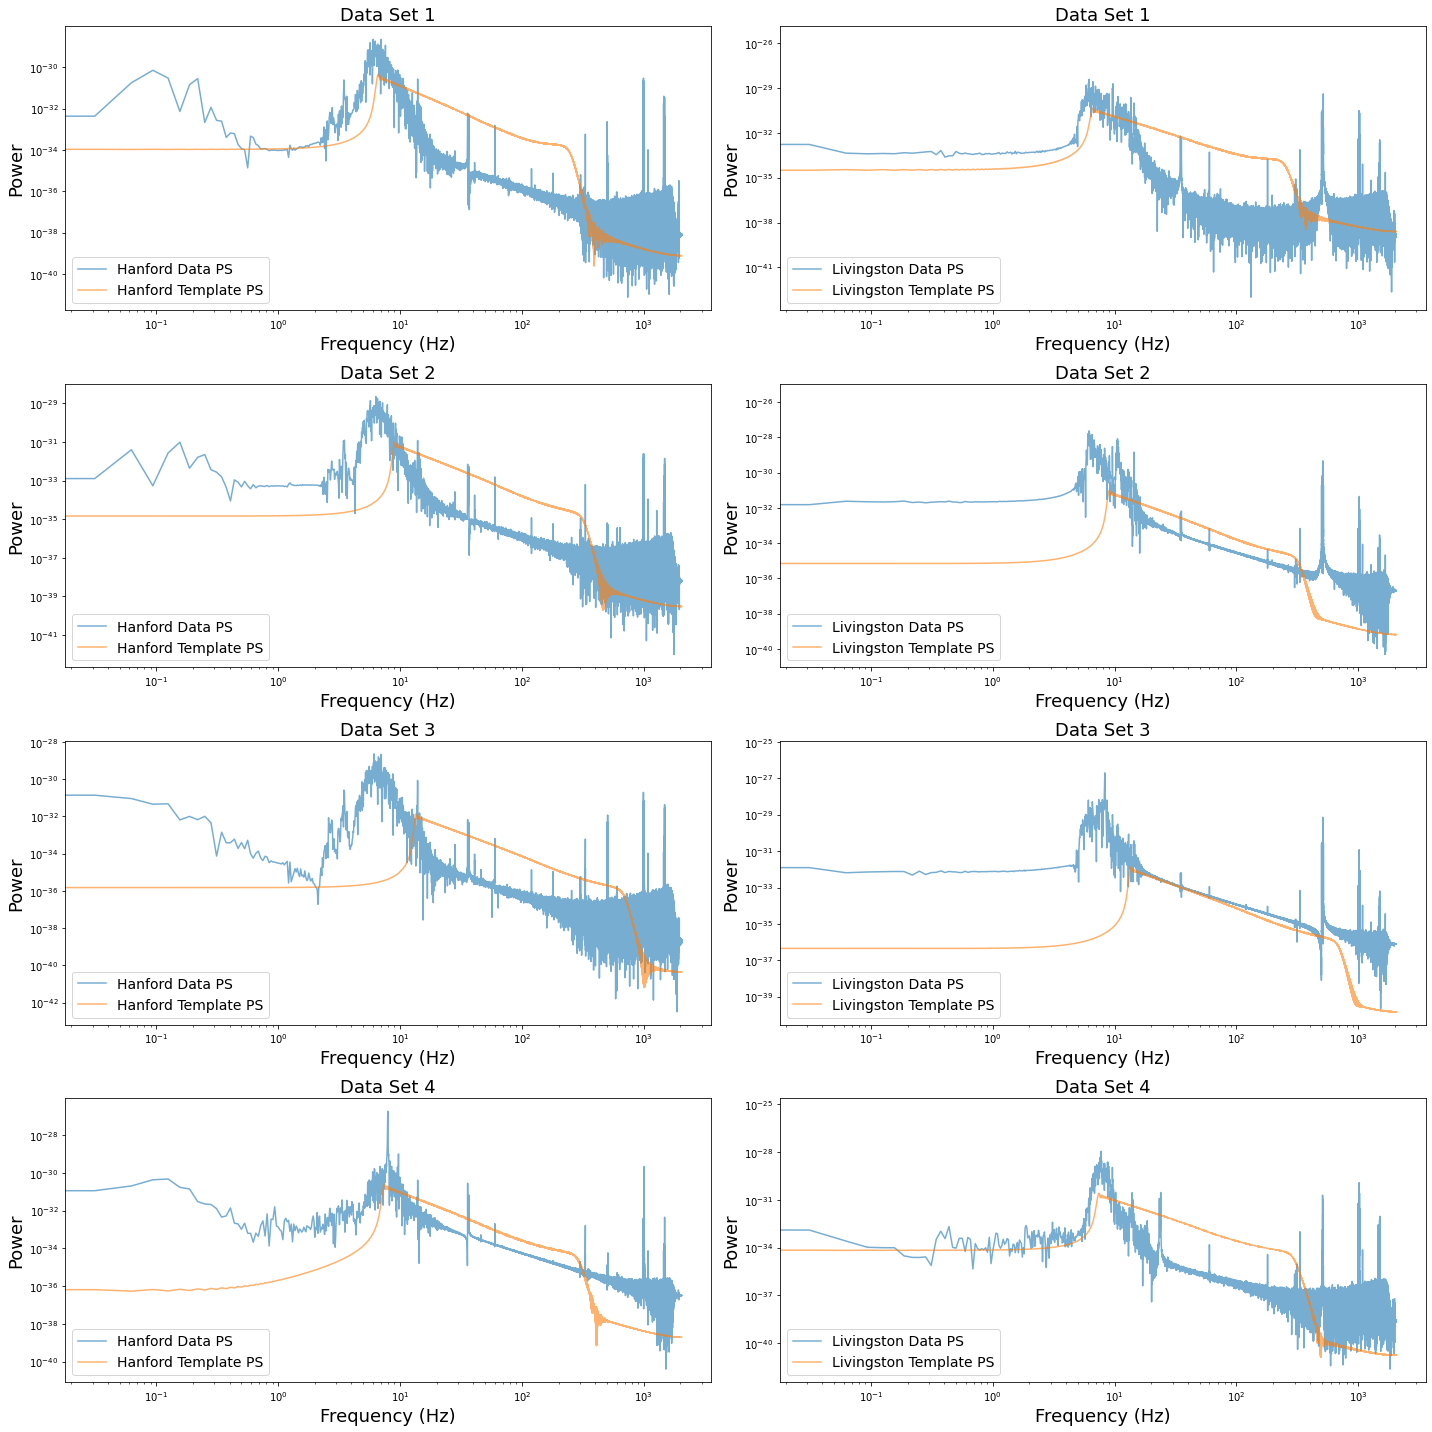

In [7]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4,2)

for i in range (4):
    # _h = hanford
    ax[i, 0].loglog(freqs, ps_h[:, i], alpha=0.6, label="Hanford Data PS")
    ax[i, 0].loglog(freqs, ps_template_h[:, i], alpha=0.6, label="Hanford Template PS")
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 0].set_ylabel("Power", fontsize=18)
    ax[i, 0].legend(fontsize=14, loc=3)
    
    # _l = livingston
    ax[i, 1].loglog(freqs, ps_l[:, i], alpha=0.6, label="Livingston Data PS")
    ax[i, 1].loglog(freqs, ps_template_l[:, i], alpha=0.6, label="Livingston Template PS")
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 1].set_ylabel("Power", fontsize=18)
    ax[i, 1].legend(fontsize=14, loc=3)


plt.tight_layout()
plt.show()

# Windowing

To window the data, I will use Nuttal window.

In [8]:
window = wind.nuttall(131072)

strain_h_ft_w = np.zeros((65537, 4), dtype=np.complex_)
ps_h_w = np.zeros((65537, 4))

strain_l_ft_w =  np.zeros((65537, 4), dtype=np.complex_)
ps_l_w = np.zeros((65537, 4))

template_h_ft_w = np.zeros((65537, 4), dtype=np.complex_)
ps_template_h_w = np.zeros((65537, 4))

template_l_ft_w = np.zeros((65537, 4), dtype=np.complex_)
ps_template_l_w = np.zeros((65537, 4))

for i in range (4):
    strain_h_ft_w[:, i] = np.fft.rfft(window*strain_h[:, i])
    ps_h_w[:, i] = abs(strain_h_ft_w[:, i])**2

    strain_l_ft_w[:, i] = np.fft.rfft(window*strain_l[:, i])
    ps_l_w[:, i] = abs(strain_l_ft_w[:, i])**2

    template_h_ft_w[:, i] = np.fft.rfft(window*template_h[:, i])
    ps_template_h_w[:, i] = np.abs(template_h_ft_w[:, i])**2

    template_l_ft_w[:, i] = np.fft.rfft(window*template_l[:, i])
    ps_template_l_w[:, i] = np.abs(template_l_ft_w[:, i])**2

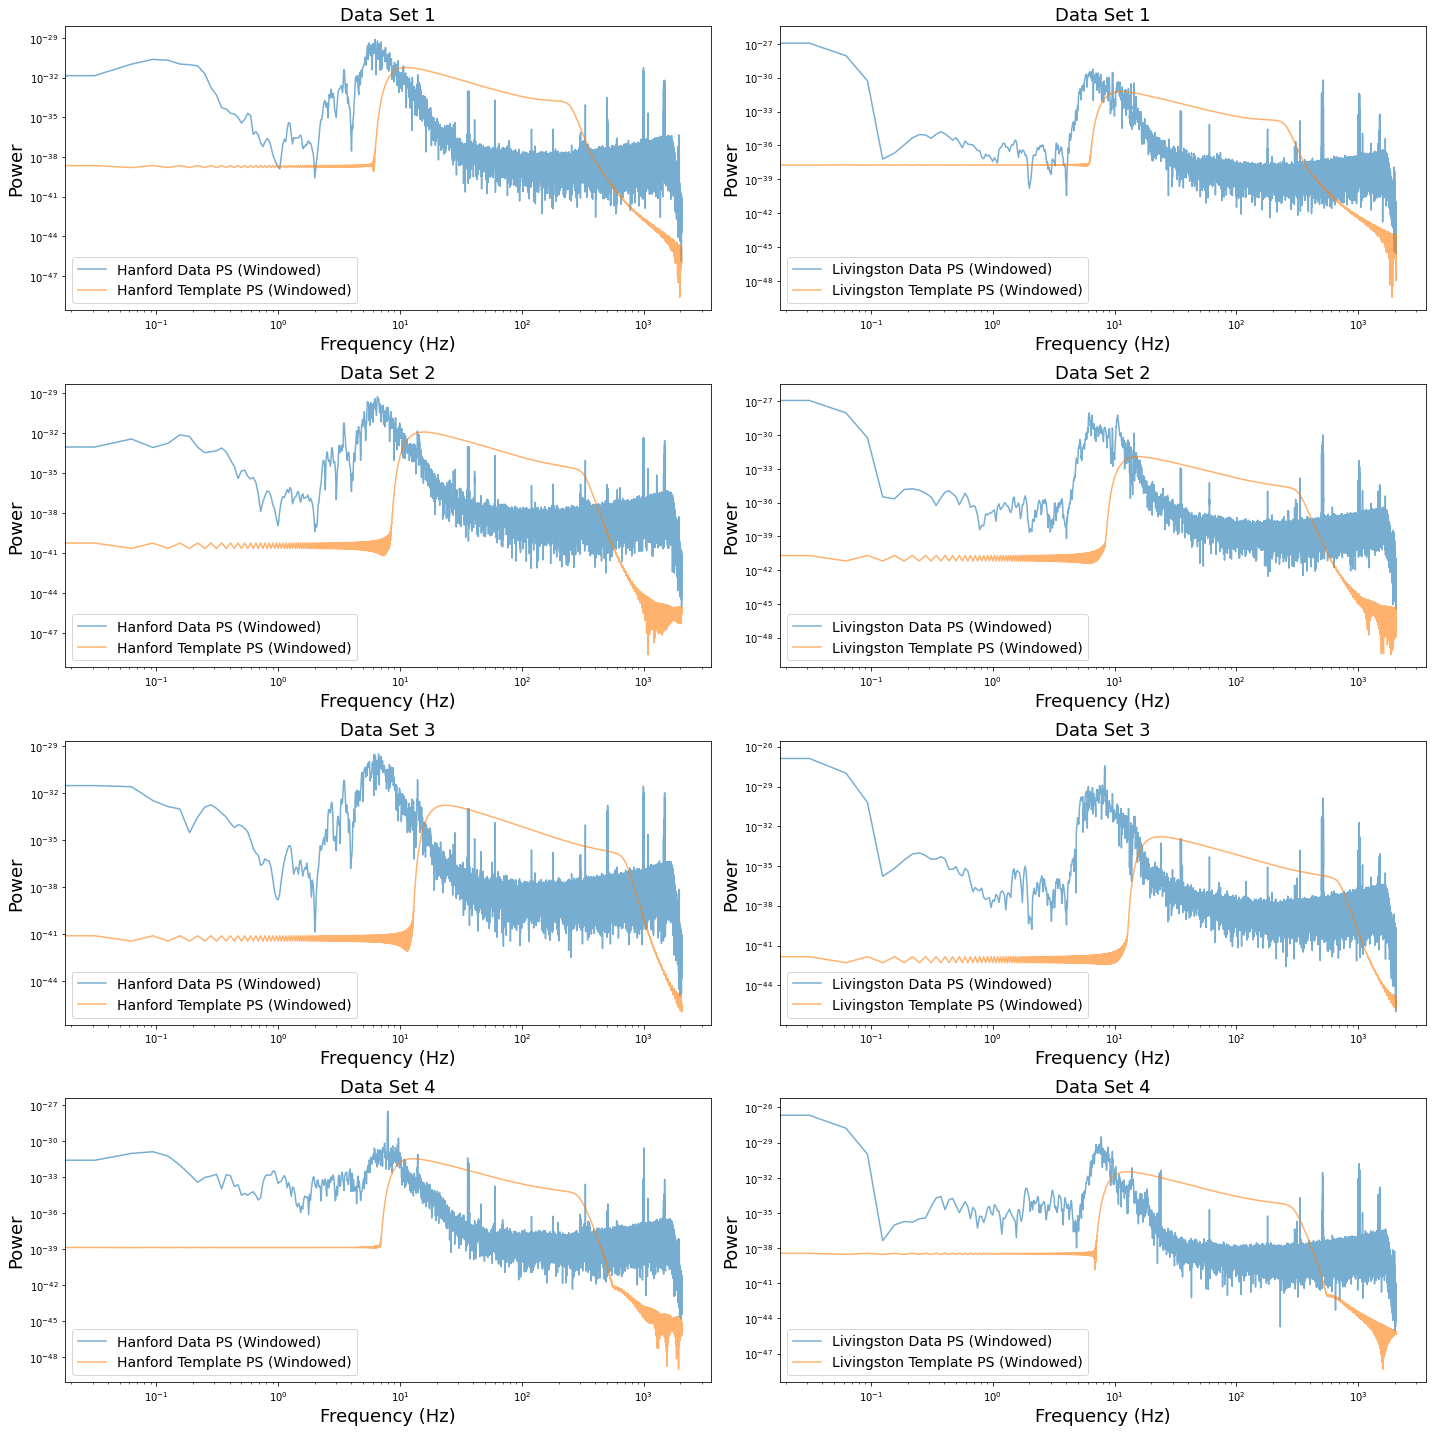

In [9]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4,2)

for i in range (4):
    # _h = hanford
    ax[i, 0].loglog(freqs, ps_h_w[:, i], alpha=0.6, label="Hanford Data PS (Windowed)")
    ax[i, 0].loglog(freqs, ps_template_h_w[:, i], alpha=0.6, label="Hanford Template PS (Windowed)")
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 0].set_ylabel("Power", fontsize=18)
    ax[i, 0].legend(fontsize=14, loc=3)
    
    # _l = livingston
    ax[i, 1].loglog(freqs, ps_l_w[:, i], alpha=0.6, label="Livingston Data PS (Windowed)")
    ax[i, 1].loglog(freqs, ps_template_l_w[:, i], alpha=0.6, label="Livingston Template PS (Windowed)")
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 1].set_ylabel("Power", fontsize=18)
    ax[i, 1].legend(fontsize=14, loc=3)


plt.tight_layout()
plt.show()

# cleaning up the frequency information

 I will only keep those regions of frequency that our noise seems to be white (approximately between 15 to 1500 Hz)

In [10]:
ind_low = np.argmin(abs(freqs - 15))
ind_high = np.argmin(abs(freqs - 1500))

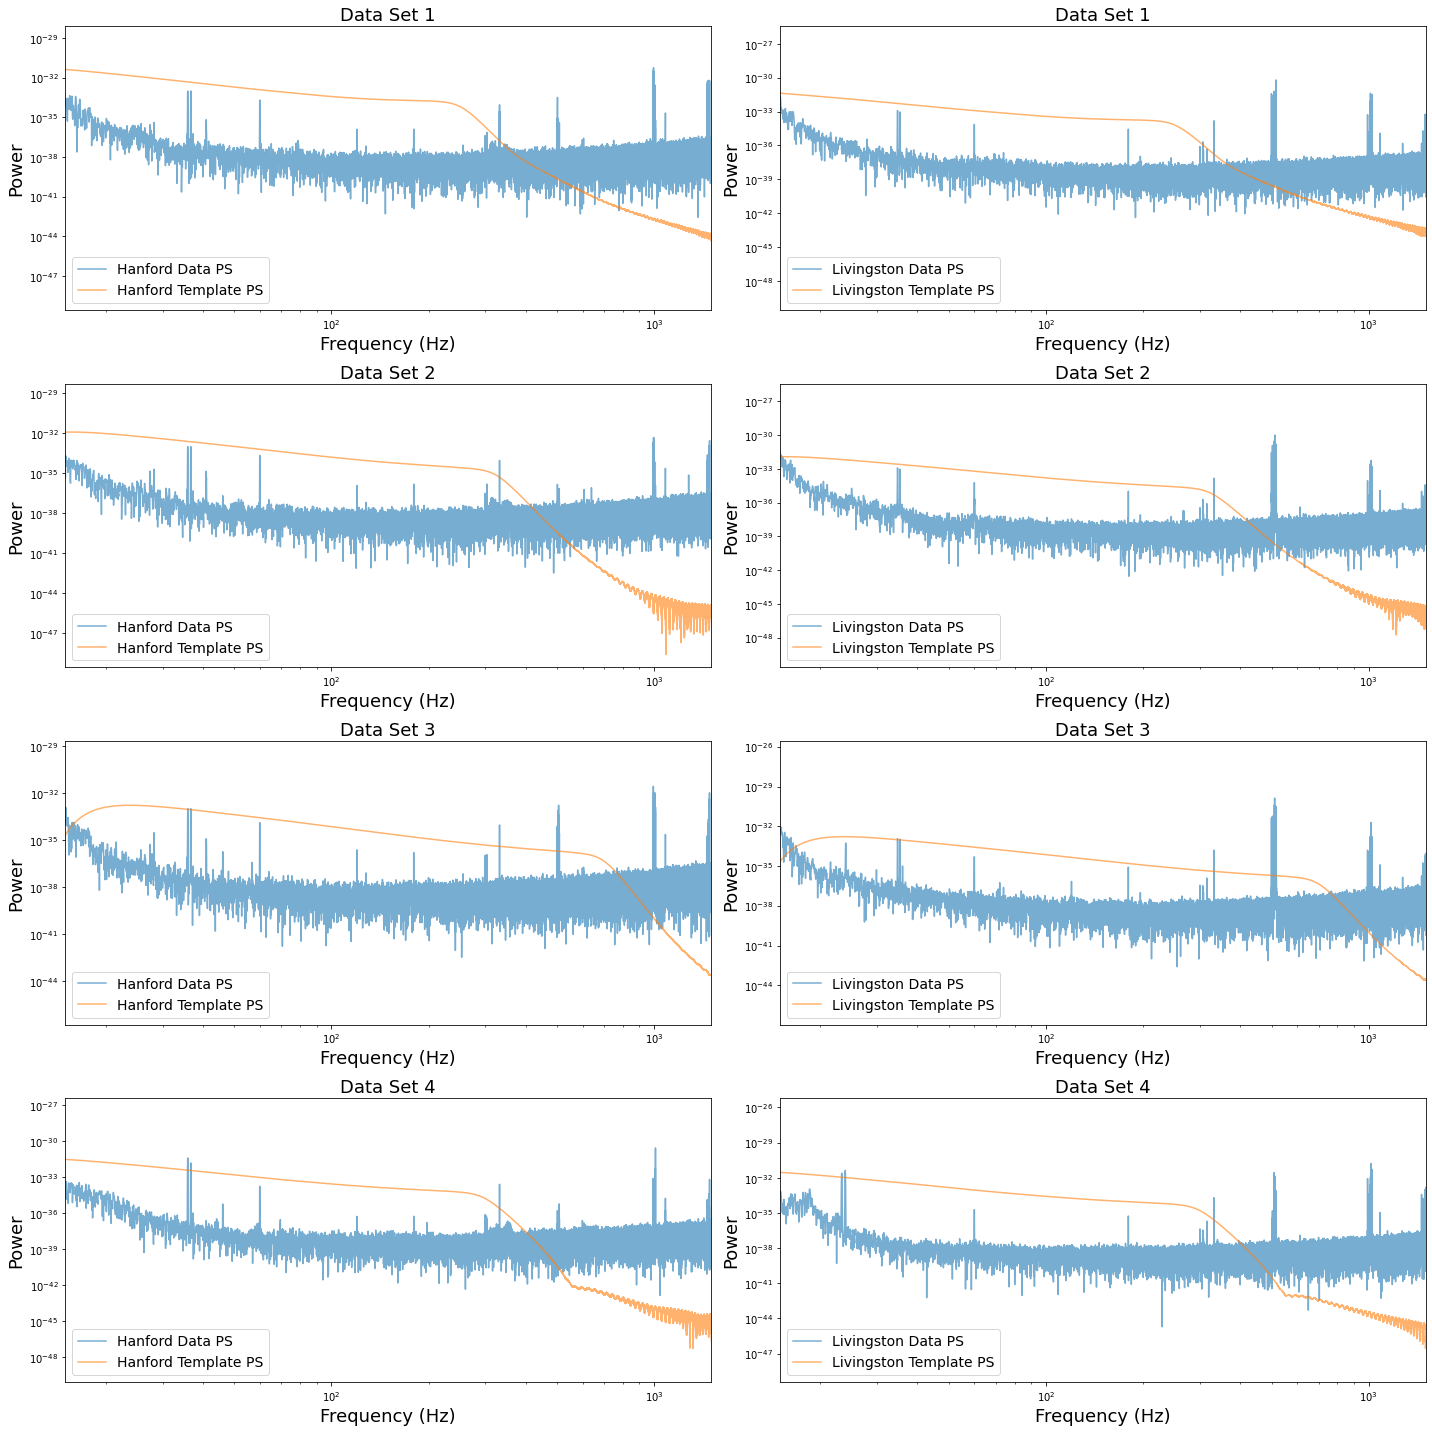

In [11]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4,2)

for i in range (4):
    # _h = hanford
    ax[i, 0].loglog(freqs, ps_h_w[:, i], alpha=0.6, label="Hanford Data PS")
    ax[i, 0].loglog(freqs, ps_template_h_w[:, i], alpha=0.6, label="Hanford Template PS")
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 0].set_ylabel("Power", fontsize=18)
    ax[i, 0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
    ax[i, 0].legend(fontsize=14, loc=3)
    
    # _l = livingston
    ax[i, 1].loglog(freqs, ps_l_w[:, i], alpha=0.6, label="Livingston Data PS")
    ax[i, 1].loglog(freqs, ps_template_l_w[:, i], alpha=0.6, label="Livingston Template PS")
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 1].set_ylabel("Power", fontsize=18)
    ax[i, 1].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
    ax[i, 1].legend(fontsize=14, loc=3)


plt.tight_layout()
plt.show()

# Smoothing

In order to smooth the power spectrum, I will use the scipy gaussian filter.

In [12]:
ps_h_w_smooth = np.zeros((65537, 4))
ps_l_w_smooth = np.zeros((65537, 4))
for i in range(4):    
    ps_h_w_smooth[:, i] = gaussian_filter(ps_h_w[:, i], sigma=50)
    ps_l_w_smooth[:, i] = gaussian_filter(ps_l_w[:, i], sigma=50)

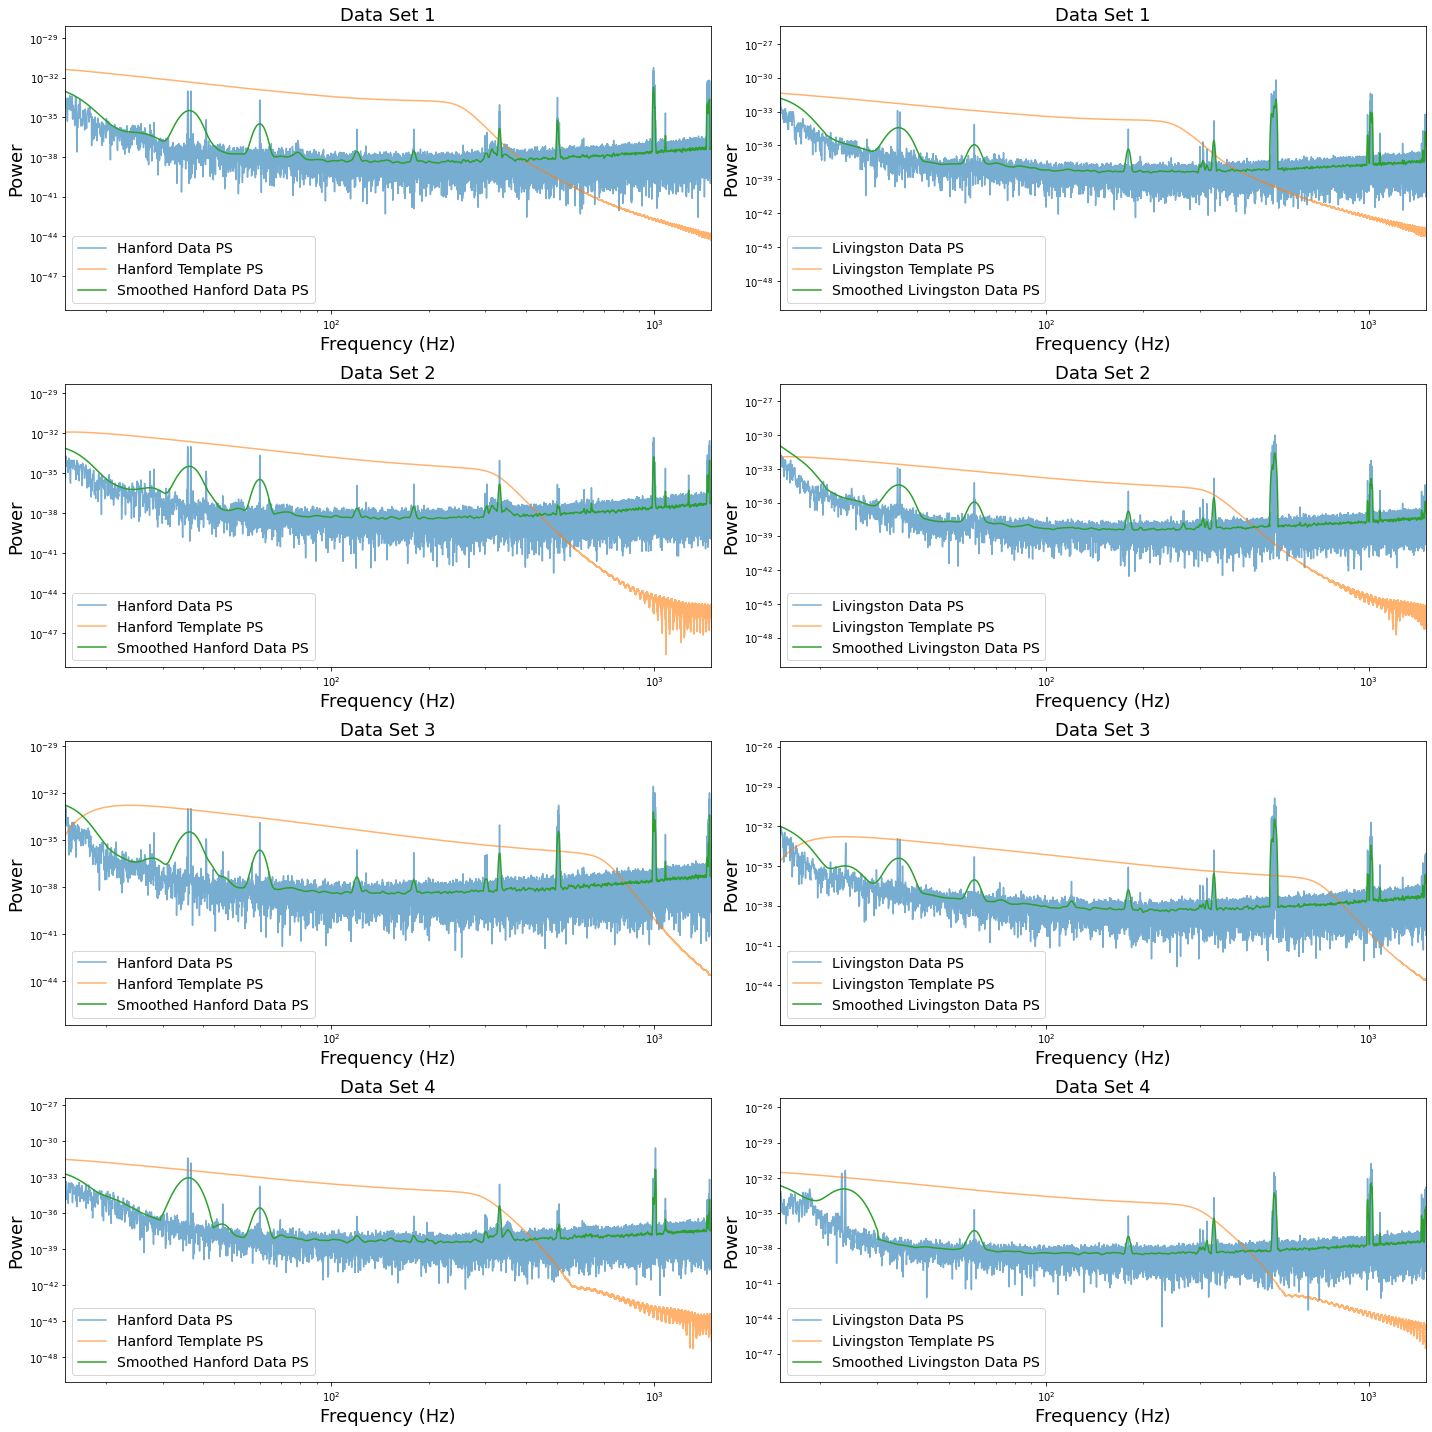

In [13]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4,2)

for i in range (4):
    # _h = hanford
    ax[i, 0].loglog(freqs, ps_h_w[:, i], alpha=0.6, label="Hanford Data PS")
    ax[i, 0].loglog(freqs, ps_template_h_w[:, i], alpha=0.6, label="Hanford Template PS")
    ax[i, 0].loglog(freqs, ps_h_w_smooth[:, i], alpha=1, label="Smoothed Hanford Data PS")
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 0].set_ylabel("Power", fontsize=18)
    ax[i, 0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
    ax[i, 0].legend(fontsize=14, loc=3)
    
    # _l = livingston
    ax[i, 1].loglog(freqs, ps_l_w[:, i], alpha=0.6, label="Livingston Data PS")
    ax[i, 1].loglog(freqs, ps_template_l_w[:, i], alpha=0.6, label="Livingston Template PS")
    ax[i, 1].loglog(freqs, ps_l_w_smooth[:, i], alpha=1, label="Smoothed Livingston Data PS")
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Frequency (Hz)", fontsize=18)
    ax[i, 1].set_ylabel("Power", fontsize=18)
    ax[i, 1].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
    ax[i, 1].legend(fontsize=14, loc=3)


plt.tight_layout()
plt.show()

In [14]:
#N : Noise Model
N_h = ps_h_w_smooth
N_l = ps_l_w_smooth
N_h_inv_sqrt = np.zeros((65537, 4))
N_l_inv_sqrt = np.zeros((65537, 4))
N_h_inv_sqrt = 1/np.sqrt(N_h)
N_l_inv_sqrt = 1/np.sqrt(N_l)

In [15]:
for array in [N_h_inv_sqrt, N_l_inv_sqrt]:
    array[:ind_low] = 0
    array[ind_high:] = 0

# b

In [16]:
#prewhitening
strain_h_ft_whitened = np.zeros((65537, 4), dtype=np.complex_)
strain_h_whitened = np.zeros((131072, 4))

strain_l_ft_whitened = np.zeros((65537, 4), dtype=np.complex_)
strain_l_whitened = np.zeros((131072, 4))

template_h_ft_whitened = np.zeros((65537, 4), dtype=np.complex_)
template_h_whitened = np.zeros((131072, 4))

template_l_ft_whitened = np.zeros((65537, 4), dtype=np.complex_)
template_l_whitened = np.zeros((131072, 4))
for i in range (4):
    strain_h_ft_whitened[:, i] = N_h_inv_sqrt[:, i]*strain_h_ft_w[:, i]
    strain_h_whitened[:, i] = np.fft.irfft(strain_h_ft_whitened[:, i], n)
    
    strain_l_ft_whitened[:, i] = strain_l_ft_w[:, i]*N_l_inv_sqrt[:, i]
    strain_l_whitened[:, i] = np.fft.irfft(strain_l_ft_whitened[:, i], n)
    
    template_h_ft_whitened[:, i] = template_h_ft_w[:, i]*N_h_inv_sqrt[:, i]
    template_h_whitened[:, i] = np.fft.irfft(template_h_ft_whitened[:, i], n)
    
    template_l_ft_whitened[:, i] = template_l_ft_w[:, i]*N_l_inv_sqrt[:, i]
    template_l_whitened[:, i] = np.fft.irfft(template_l_ft_whitened[:, i], n)

In [17]:
mf_ft_h = np.zeros((65537, 4), dtype=np.complex_)
mf_h = np.zeros((131072, 4))
mf_ft_l = np.zeros((65537, 4), dtype=np.complex_)
mf_l = np.zeros((131072, 4))

#matched filter
for i in range (4):
    mf_ft_h[:, i] = strain_h_ft_whitened[:, i] * np.conj(template_h_ft_whitened[:, i])
    mf_h[:, i] = np.fft.irfft(mf_ft_h[:, i], n)
    
    mf_ft_l[:, i] = strain_l_ft_whitened[:, i] * np.conj(template_l_ft_whitened[:, i])
    mf_l[:, i] = np.fft.irfft(mf_ft_l[:, i], n)

In [18]:
#time array
time = np.arange(0, n)*dt

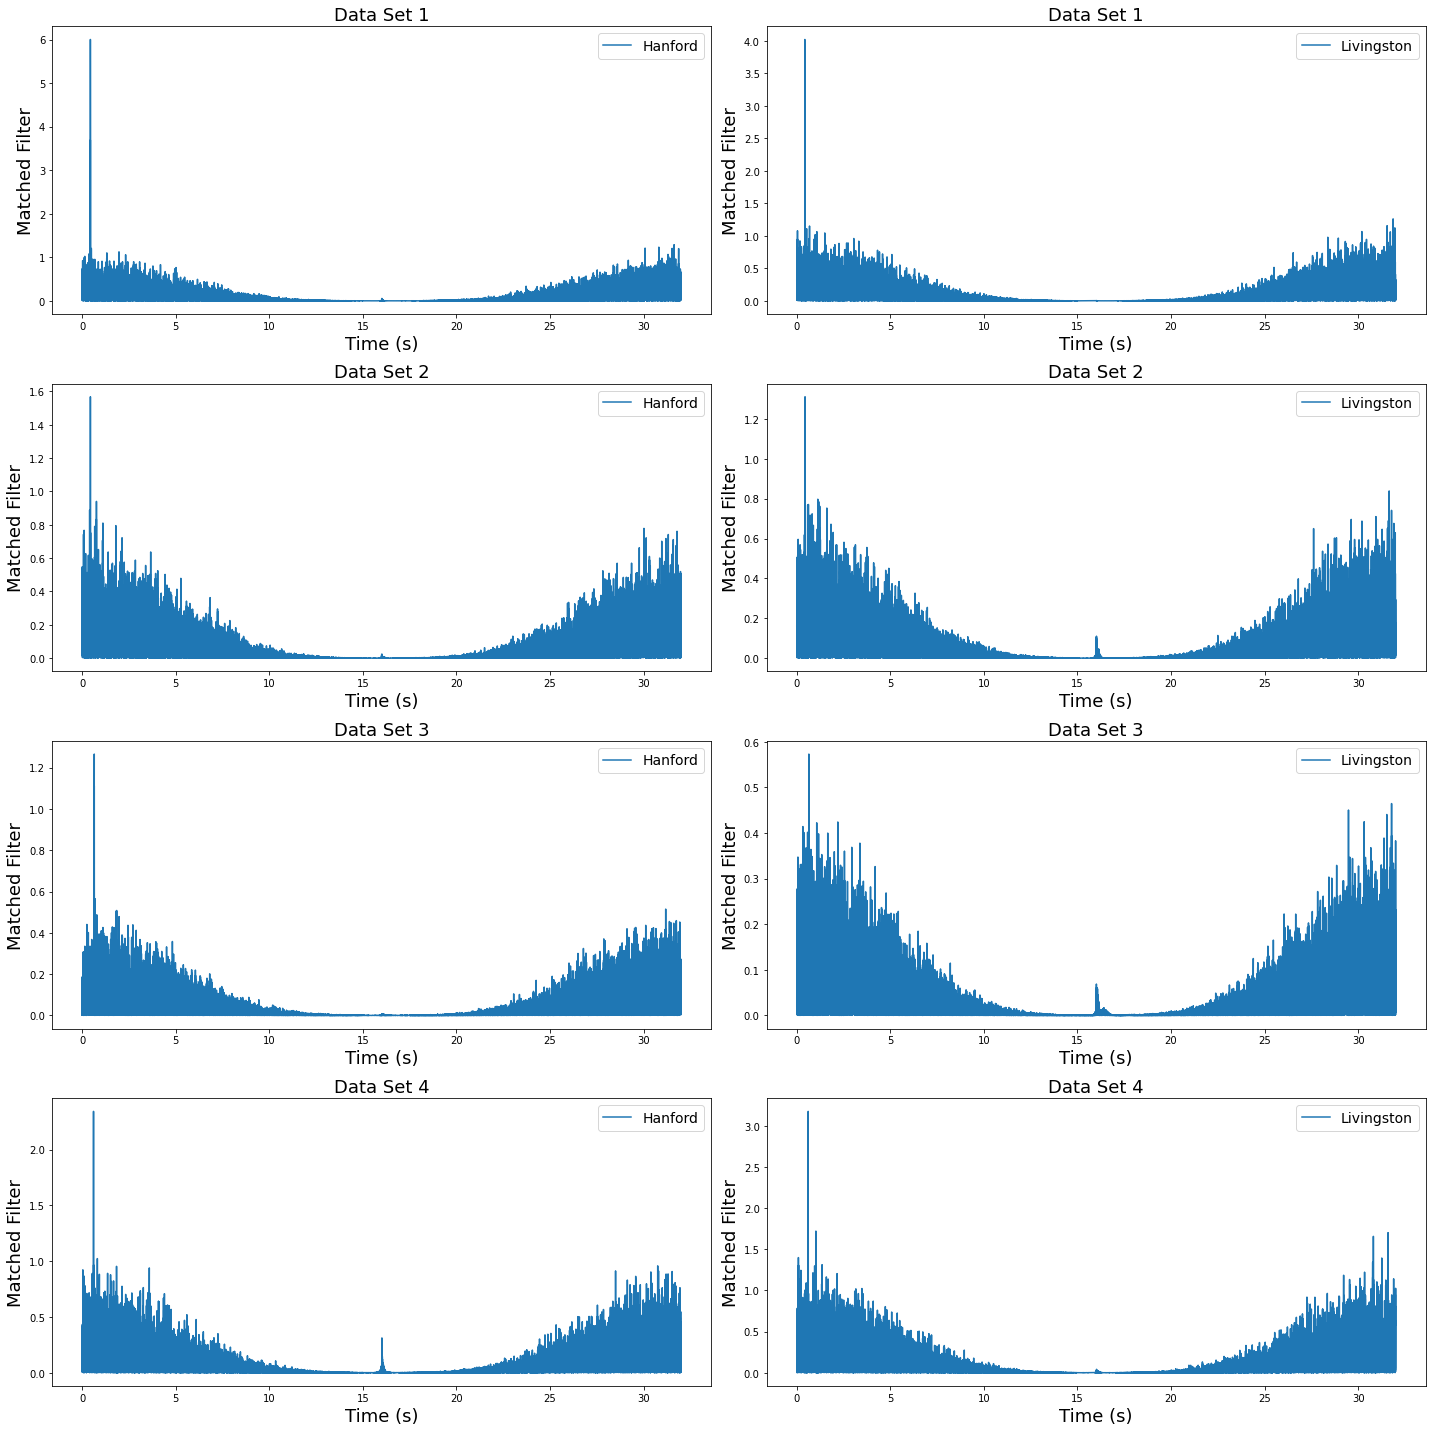

In [19]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4, 2)

for i in range (4):
    # _h = hanford
    ax[i, 0].plot(time, abs(mf_h[:, i]),label='Hanford')
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Time (s)", fontsize=18)
    ax[i, 0].set_ylabel("Matched Filter", fontsize=18)
    ax[i, 0].legend(fontsize=14, loc=1)
    
    # _l = livingston
    ax[i, 1].plot(time, abs(mf_l[:, i]),label='Livingston')
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Time (s)", fontsize=18)
    ax[i, 1].set_ylabel("Matched Filter", fontsize=18)
    ax[i, 1].legend(fontsize=14, loc=1)

plt.tight_layout()
plt.show()

# C

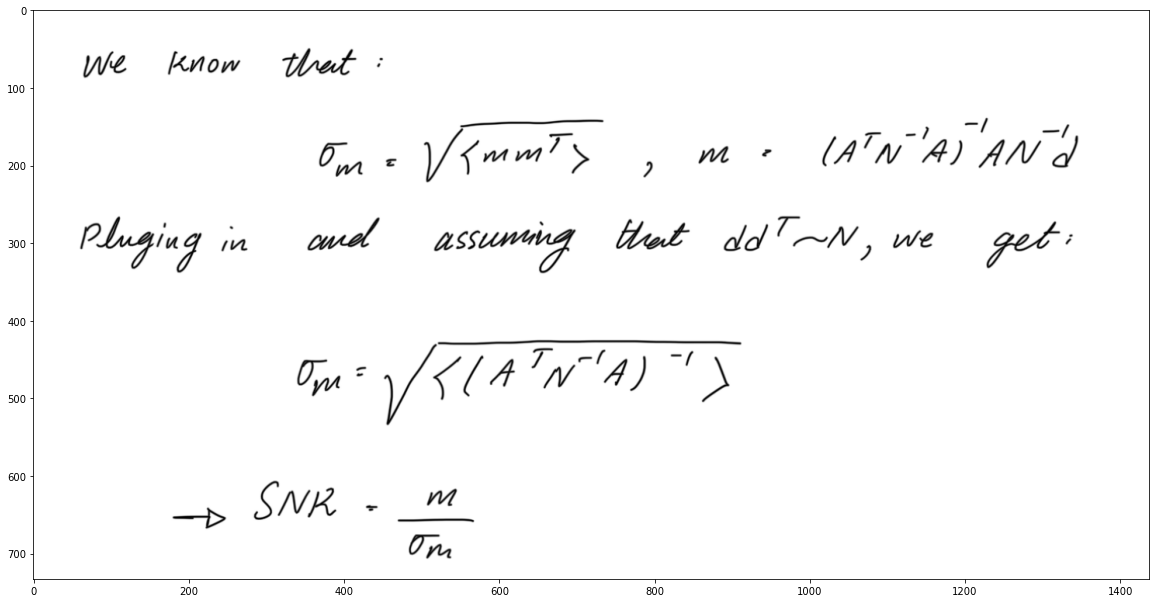

In [20]:
img = mpimg.imread('2.PNG')
plt.imshow(img)
plt.show()

In [21]:
#SNR
#first I Calculate the noise and SNR from individual detectors for different data sets. 
#Then, I will calculate the combined version 

#individual detectors
sigma_h = np.zeros(4)
sigma_l = np.zeros(4)
SNR_h = np.zeros((131072, 4))
SNR_l = np.zeros((131072, 4))
for i in range(4):
    sigma_h[i] = np.sqrt(np.mean(template_h_whitened[:, i]**2))
    sigma_l[i] = np.sqrt(np.mean(template_l_whitened[:, i]**2))
    SNR_h[:, i] = mf_h[:, i]/sigma_h[i]
    SNR_l[:, i] = mf_l[:, i]/sigma_l[i]

In [22]:
print("Noise estimate for Hanford: ", sigma_h)
print("Noise estimate for Livingston: ", sigma_l)

Noise estimate for Hanford:  [0.19445047 0.12398193 0.08376535 0.15991341]
Noise estimate for Livingston:  [0.17768354 0.12121028 0.06507541 0.21963794]


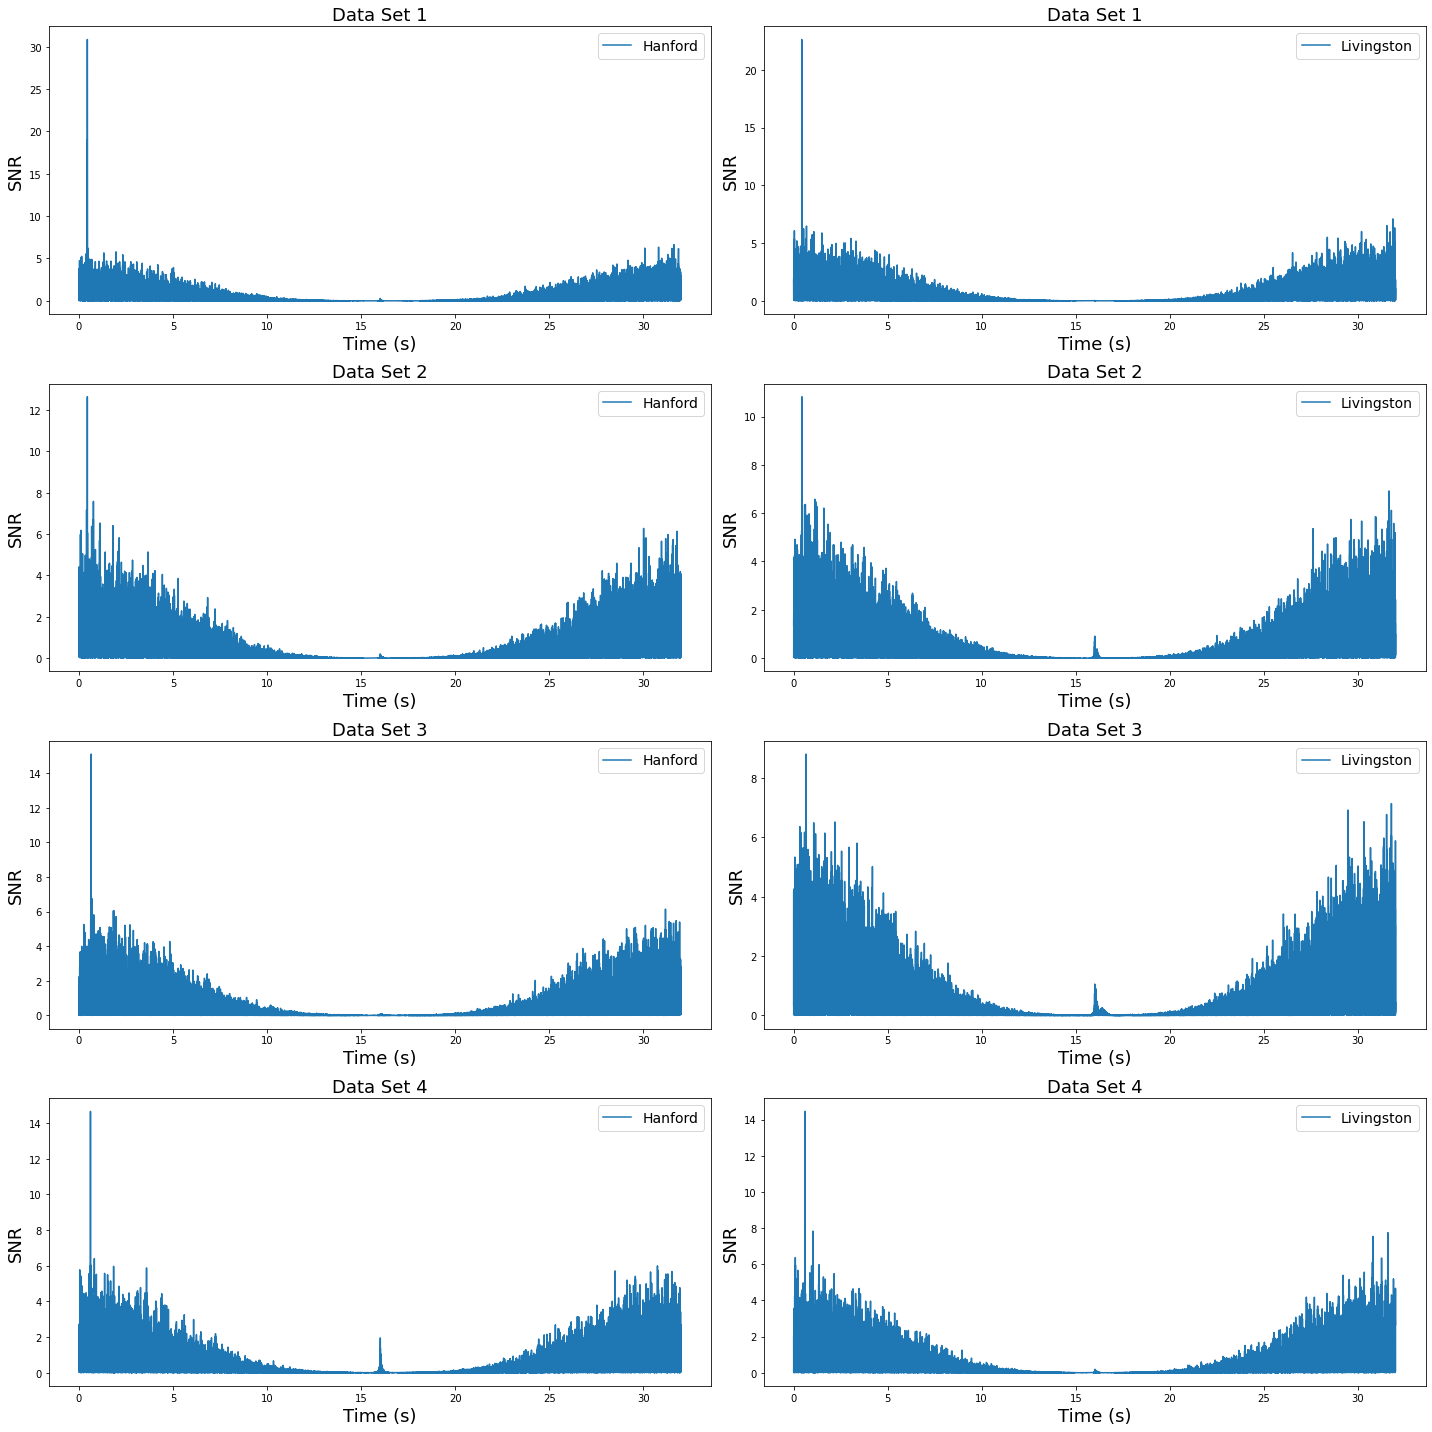

In [23]:
rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots(4, 2)

for i in range (4):
    # _h = hanford
    ax[i, 0].plot(time, abs(SNR_h[:, i]),label='Hanford')
    ax[i, 0].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 0].set_xlabel("Time (s)", fontsize=18)
    ax[i, 0].set_ylabel("SNR", fontsize=18)
    ax[i, 0].legend(fontsize=14, loc=1)
    
    # _l = livingston
    ax[i, 1].plot(time, abs(SNR_l[:, i]),label='Livingston')
    ax[i, 1].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i, 1].set_xlabel("Time (s)", fontsize=18)
    ax[i, 1].set_ylabel("SNR", fontsize=18)
    ax[i, 1].legend(fontsize=14, loc=1)

plt.tight_layout()
plt.show()

Total SNR:

$$\text{SNR}_\text{tot} = \sqrt{\text{SNR}_\text{h}^2 + \text{SNR}_\text{l}^2}$$

In [24]:
SNR_t = np.zeros((131072, 4))
for i in range(4):
    SNR_t[:, i] = np.sqrt(SNR_h[:, i]**2 + SNR_l[:, i]**2)

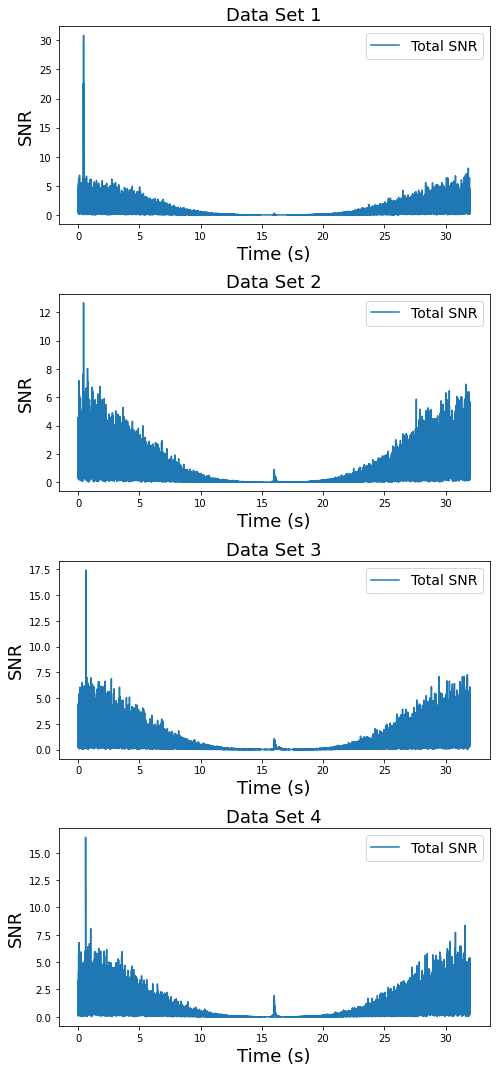

In [25]:
rcParams['figure.figsize'] = (7, 15)
fig, ax = plt.subplots(4, 1)

for i in range (4):
    # _h = hanford
    ax[i].plot(time, abs(SNR_t[:, i]), label='Total SNR')
    ax[i].set_title('Data Set %d'%(i+1) , fontsize=18)
    ax[i].set_xlabel("Time (s)", fontsize=18)
    ax[i].set_ylabel("SNR", fontsize=18)
    ax[i].legend(fontsize=14, loc=1)

plt.tight_layout()
plt.show()

In [26]:
for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    print("Hanford matched filter SNR : %.2f" % (abs(SNR_h[:, i]).max()))
    print("Livingston matched filter SNR : %.2f" % (abs(SNR_l[:, i]).max()))
    print("Total matched filter SNR : %.2f" % (abs(SNR_t[:, i]).max()))


Data set number 1
Hanford matched filter SNR : 30.86
Livingston matched filter SNR : 22.64
Total matched filter SNR : 30.86

Data set number 2
Hanford matched filter SNR : 12.65
Livingston matched filter SNR : 10.82
Total matched filter SNR : 12.68

Data set number 3
Hanford matched filter SNR : 15.11
Livingston matched filter SNR : 8.81
Total matched filter SNR : 17.43

Data set number 4
Hanford matched filter SNR : 14.65
Livingston matched filter SNR : 14.46
Total matched filter SNR : 16.42


# d

In [27]:
#finding the matched filters best region (close to the peak, thus less affected by the shape of the window function)
rms_h = np.zeros(4)
rms_l = np.zeros(4)
SNR_h_2 = np.zeros((131072, 4))
SNR_l_2 = np.zeros((131072, 4))

for i in range(4):
    rms_h[i]= np.std(mf_h[np.argmax(mf_h[:, i])+100:np.argmax(mf_h[:, i])+1100])
    rms_l[i]= np.std(mf_l[np.argmax(mf_l[:, i])+100:np.argmax(mf_l[:, i])+1100])

    SNR_h_2[:, i] = abs(mf_h[:, i])/rms_h[i]
    SNR_l_2[:, i] = abs(mf_l[:, i])/rms_l[i]

In [28]:
SNR_t_2 = np.zeros((131072, 4))
for i in range(4):
    SNR_t_2[:, i] = np.sqrt(SNR_h_2[:, i]**2 + SNR_l_2[:, i]**2)

In [29]:
for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    print("Hanford matched filter scatter SNR: %.2f" % (abs(SNR_h_2[:, i]).max()))
    print("Livingston matched filter scatter SNR: %.2f" % (abs(SNR_l_2[:, i]).max()))
    print("Total matched filter scatter SNR: %.2f" % (abs(SNR_t_2[:, i]).max()))


Data set number 1
Hanford matched filter scatter SNR: 19.58
Livingston matched filter scatter SNR: 10.71
Total matched filter scatter SNR: 19.58

Data set number 2
Hanford matched filter scatter SNR: 5.13
Livingston matched filter scatter SNR: 3.47
Total matched filter scatter SNR: 5.14

Data set number 3
Hanford matched filter scatter SNR: 4.55
Livingston matched filter scatter SNR: 1.97
Total matched filter scatter SNR: 4.94

Data set number 4
Hanford matched filter scatter SNR: 8.11
Livingston matched filter scatter SNR: 10.84
Total matched filter scatter SNR: 11.22


In [30]:
#difference between SNRs
for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    print("Hanford SNR difference: %.2f" % (abs(SNR_h[:, i]).max() - abs(SNR_h_2[:, i]).max()))
    print("Livingston SNR difference: %.2f" % (abs(SNR_l[:, i]).max() - abs(SNR_l_2[:, i]).max()))
    print("Total SNR difference: %.2f" % (abs(SNR_t[:, i]).max() - abs(SNR_t_2[:, i]).max()))


Data set number 1
Hanford SNR difference: 11.28
Livingston SNR difference: 11.93
Total SNR difference: 11.28

Data set number 2
Hanford SNR difference: 7.51
Livingston SNR difference: 7.34
Total SNR difference: 7.54

Data set number 3
Hanford SNR difference: 10.56
Livingston SNR difference: 6.84
Total SNR difference: 12.49

Data set number 4
Hanford SNR difference: 6.55
Livingston SNR difference: 3.62
Total SNR difference: 5.20


The SNR we get by scatter is lower than we get using the analytic formula.

 The disagreement may come from the approximations used when constructing our noise model

# e

In [31]:
template_h_ps = np.zeros((65537, 4))
template_l_ps = np.zeros((65537, 4))
cumsum_h = np.zeros((65537, 4))
cumsum_l = np.zeros((65537, 4))
ind_freq_h = np.zeros(4)
ind_freq_l = np.zeros(4)

for i in range(4):
    # Power spectra of whitened templates
    template_h_ps[:, i] = abs(template_h_ft_whitened[:, i])**2
    template_l_ps[:, i] = abs(template_l_ft_whitened[:, i])**2

    # Make the cumulative sum arrays
    cumsum_h[:, i] = np.cumsum(template_h_ps[:, i])
    cumsum_l[:, i] = np.cumsum(template_l_ps[:, i])
    arg1 = abs(cumsum_h[:, i] - template_h_ps[:, i].sum()/2.)
    arg2 = abs(cumsum_l[:, i] - template_l_ps[:, i].sum()/2.)
    
    # Find the index closest to half the total sum
    ind_freq_h[i] = np.argmin(arg1)
    ind_freq_l[i] = np.argmin(arg2)

In [32]:
for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    a = int(ind_freq_h[i])
    b = int(ind_freq_l[i])
    print('Hanford Half Power Frequency: %.2f Hz' % (freqs[a]))
    print('Livingston Half Power Frequency: %.2f Hz' % (freqs[b]))


Data set number 1
Hanford Half Power Frequency: 123.53 Hz
Livingston Half Power Frequency: 125.50 Hz

Data set number 2
Hanford Half Power Frequency: 99.28 Hz
Livingston Half Power Frequency: 103.72 Hz

Data set number 3
Hanford Half Power Frequency: 95.25 Hz
Livingston Half Power Frequency: 112.78 Hz

Data set number 4
Hanford Half Power Frequency: 110.94 Hz
Livingston Half Power Frequency: 82.03 Hz


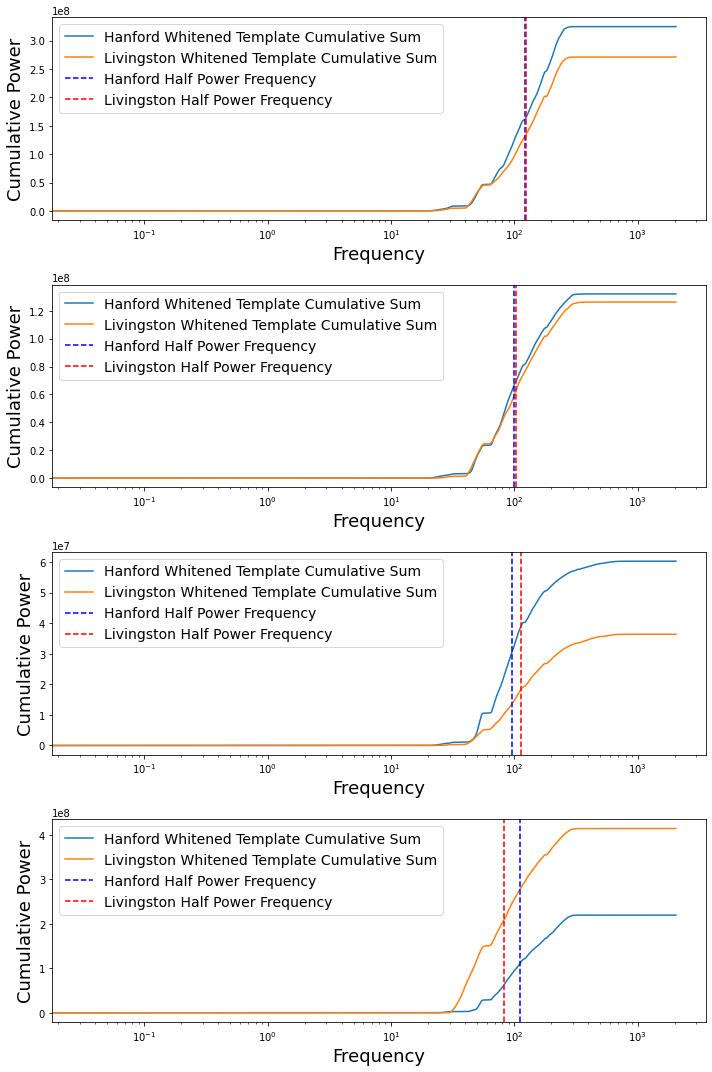

In [33]:
rcParams['figure.figsize'] = (10, 15)
fig, ax = plt.subplots(4, 1)

for i in range(4):
    
    ax[i].semilogx(freqs, cumsum_h[:, i], label='Hanford Whitened Template Cumulative Sum')
    ax[i].semilogx(freqs, cumsum_l[:, i], label='Livingston Whitened Template Cumulative Sum')
    a = int(ind_freq_h[i])
    b = int(ind_freq_l[i])
    ax[i].axvline(freqs[a], ls='--',label='Hanford Half Power Frequency',c='b')
    ax[i].axvline(freqs[b], ls='--',label='Livingston Half Power Frequency',c='r')
    ax[i].legend(fontsize=14)
    ax[i].set_xlabel("Frequency", fontsize=18)
    ax[i].set_ylabel("Cumulative Power", fontsize=18)
    
plt.tight_layout()
plt.show()

# f

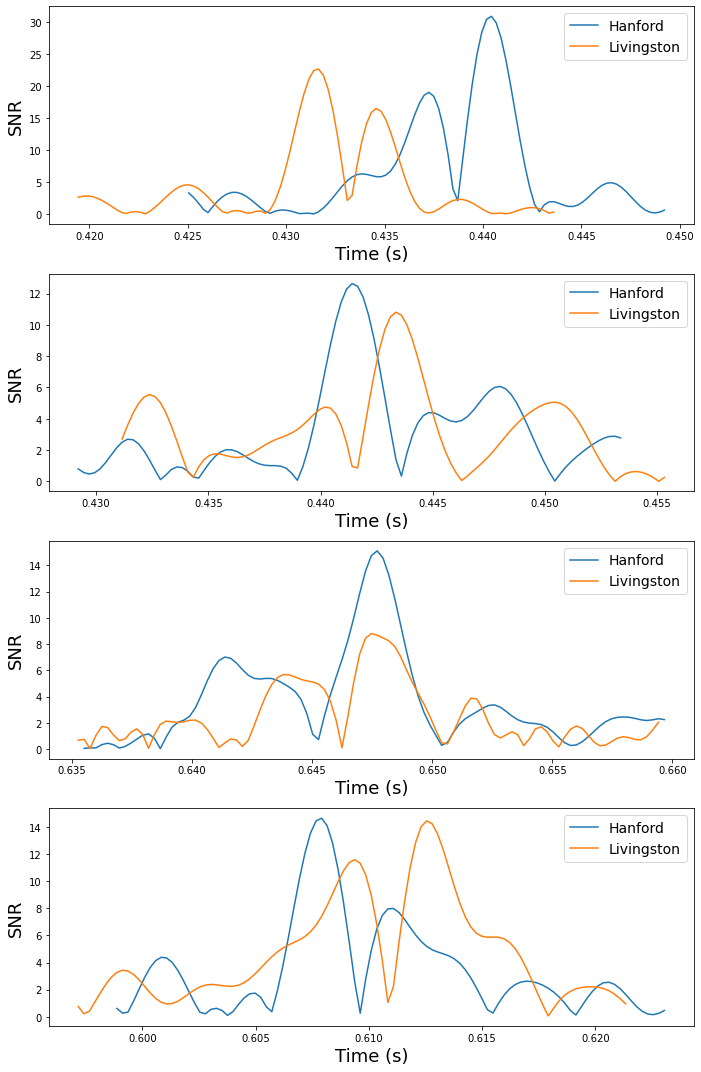

In [34]:
rcParams['figure.figsize'] = (10, 15)
fig, ax = plt.subplots(4, 1)

for i in range(4):
    ind_zoom_low_h = np.argmax(SNR_h[:, i]) - 50
    ind_zoom_high_h = np.argmax(SNR_h[:, i]) + 50
    
    ind_zoom_low_l = np.argmax(SNR_l[:, i]) - 50
    ind_zoom_high_l = np.argmax(SNR_l[:, i]) + 50
    
    ax[i].plot(time[ind_zoom_low_h:ind_zoom_high_h], abs(SNR_h[:, i])[ind_zoom_low_h:ind_zoom_high_h], label='Hanford')
    ax[i].plot(time[ind_zoom_low_l:ind_zoom_high_l], abs(SNR_l[:, i])[ind_zoom_low_l:ind_zoom_high_l], label='Livingston')
    
    ax[i].set_xlabel("Time (s)", fontsize=18)
    ax[i].set_ylabel("SNR",fontsize=18)
    ax[i].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [35]:
delta = np.zeros(4)

for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    delta[i] = abs(time[np.argmax(abs(SNR_l[:, i]))] - time[np.argmax(abs(SNR_h[:, i]))])
    print('Hanford Time of arrival: %.2e s' %time[np.argmax(abs(SNR_h[:, i]))])
    print('Livingstone Time of arrival: %.2e s' %time[np.argmax(abs(SNR_l[:, i]))])
    print("Difference in arrival time of GW between Hanford and Livingston: %.2e s" % (delta[i]))


Data set number 1
Hanford Time of arrival: 4.40e-01 s
Livingstone Time of arrival: 4.32e-01 s
Difference in arrival time of GW between Hanford and Livingston: 8.79e-03 s

Data set number 2
Hanford Time of arrival: 4.41e-01 s
Livingstone Time of arrival: 4.43e-01 s
Difference in arrival time of GW between Hanford and Livingston: 1.95e-03 s

Data set number 3
Hanford Time of arrival: 6.48e-01 s
Livingstone Time of arrival: 6.47e-01 s
Difference in arrival time of GW between Hanford and Livingston: 2.44e-04 s

Data set number 4
Hanford Time of arrival: 6.08e-01 s
Livingstone Time of arrival: 6.13e-01 s
Difference in arrival time of GW between Hanford and Livingston: 4.64e-03 s


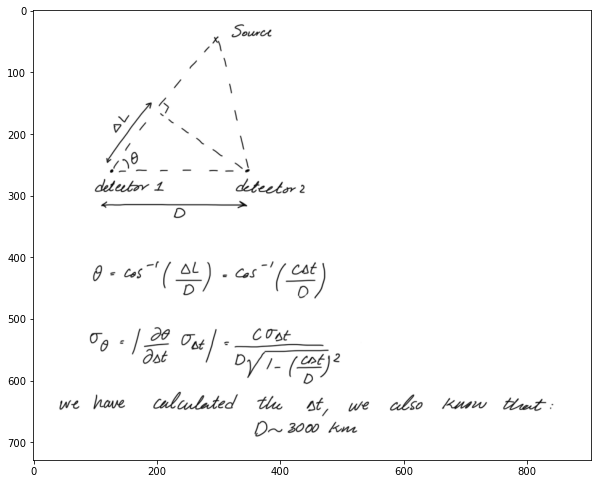

In [36]:
img = mpimg.imread('1.PNG')
plt.imshow(img)
plt.show()

In [37]:
sigma_t = 0.001
for i in range(4):
    print('\n'+'Data set number %.0f' %(i+1))
    sigma_theta = 100 * sigma_t / np.sqrt(1 - (100*delta[i])**2)
    sigma_theta_deg = np.rad2deg(sigma_theta)
    print(f"Angular Uncertainty is {sigma_theta_deg:.2f} deg.")


Data set number 1
Angular Uncertainty is 12.01 deg.

Data set number 2
Angular Uncertainty is 5.84 deg.

Data set number 3
Angular Uncertainty is 5.73 deg.

Data set number 4
Angular Uncertainty is 6.47 deg.
